<a href="https://colab.research.google.com/github/Waxpple/ML4NASA21SENSOR/blob/master/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#get file from nasa
!wget https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/train_FD001.txt
!wget https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/RUL_FD001.txt
!wget https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/test_FD001.txt

--2019-11-05 14:00:41--  https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/train_FD001.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘train_FD001.txt’

train_FD001.txt     100%[===================>]   3.35M  --.-KB/s    in 0.04s   

2019-11-05 14:00:42 (77.6 MB/s) - ‘train_FD001.txt’ saved [3515356/3515356]

--2019-11-05 14:00:43--  https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/RUL_FD001.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 429 [text/plain]
Saving 

In [2]:
import pandas as pd
import numpy as np


import os
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasClassifier

import scipy
from scipy.stats import norm

import boto3

# get rid of deprecated warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import linear_model


import matplotlib as mlab
import matplotlib.pyplot as plt
mlab.rcParams['figure.figsize']=(17,10)

Using TensorFlow backend.


In [3]:
# get the training file and call its handler "train"
train = pd.read_csv('train_FD001.txt',sep=" " ,header = None)             
test = pd.read_csv('test_FD001.txt',sep =" ",header = None)


if train.empty:
    raise Exception('No data found!')
if test.empty:
    raise Exception('No test found!')
# remove some columns and add titles
train.drop(train.columns[[26,27]],axis=1,inplace=True)
test.drop(test.columns[[26,27]],axis=1,inplace=True)

operational_columns = ['setting1','setting2','setting3']
observational_columns = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

train.columns = ['id','cycle'] + operational_columns + observational_columns 
test.columns = ['id','cycle'] + operational_columns + observational_columns 

#test = train
print(train.head())
print(test.head())

#train or test2
#test = train

   id  cycle  setting1  setting2  setting3  ...  s17   s18    s19    s20      s21
0   1      1   -0.0007   -0.0004     100.0  ...  392  2388  100.0  39.06  23.4190
1   1      2    0.0019   -0.0003     100.0  ...  392  2388  100.0  39.00  23.4236
2   1      3   -0.0043    0.0003     100.0  ...  390  2388  100.0  38.95  23.3442
3   1      4    0.0007    0.0000     100.0  ...  392  2388  100.0  38.88  23.3739
4   1      5   -0.0019   -0.0002     100.0  ...  393  2388  100.0  38.90  23.4044

[5 rows x 26 columns]
   id  cycle  setting1  setting2  setting3  ...  s17   s18    s19    s20      s21
0   1      1    0.0023    0.0003     100.0  ...  392  2388  100.0  38.86  23.3735
1   1      2   -0.0027   -0.0003     100.0  ...  393  2388  100.0  39.02  23.3916
2   1      3    0.0003    0.0001     100.0  ...  393  2388  100.0  39.08  23.4166
3   1      4    0.0042    0.0000     100.0  ...  391  2388  100.0  39.00  23.3737
4   1      5    0.0014    0.0000     100.0  ...  390  2388  100.0  38.99  2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


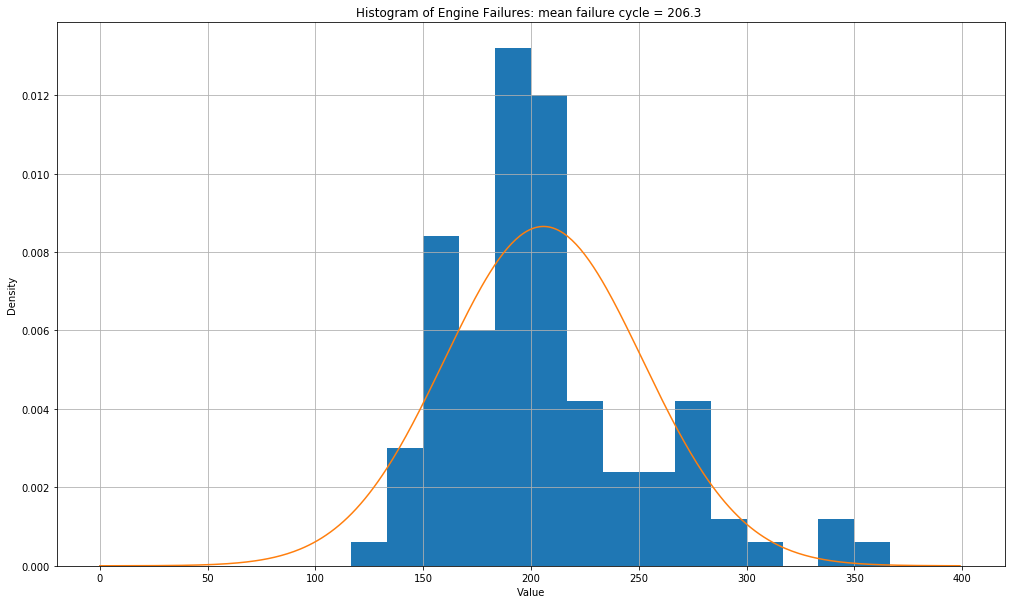

In [4]:
# draw the histogram with the average cycle of failure "mu" using:
# norm.fit and acipy.stats.norm.pdf
# plt.hist

##### TO BE COMPLETED #####                  
Data1= train.groupby(['id'], sort=False,as_index=False)['cycle'].max()
max_scatter = list(Data1['cycle'])
l_1 = np.linspace(0, 400, 25)
l_2 = np.linspace(0,400,400)

mu,std=scipy.stats.norm.fit(max_scatter)
plt.hist(max_scatter,bins=l_1,normed='true')

pdf = scipy.stats.norm.pdf
plt.plot(pdf(l_2, loc=mu, scale=std))

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Engine Failures: mean failure cycle = %.1f ' %(mu))
plt.grid(True)
plt.show()

In [0]:
# prepare the dataset

LOOKBACK_LENGTH = 10 # number of cycles in the past to analyse on a rolling basis
DAYS_IN_ADVANCE = 30 # number of cycles we consider before the engine fail

# get the "truth" data file to be used as the test dataset and call it "truth"

##### TO BE COMPLETED #####                  
truth = pd.read_csv('RUL_FD001.txt',sep=" " ,header = None) 
truth.drop(truth.columns[[1]],axis=1,inplace=True)

# for a given engine, RUL = cycle at failure - current cycle
# we add this parameter as a column to the left of the training data table
# then we drop the max column that becomes useless
train.head()
rul = pd.DataFrame(train.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id','max']
train = train.merge(rul, on=['id'], how='left')

train['RUL'] = train['max'] - train['cycle']
train.drop('max', axis=1, inplace=True)

In [6]:
# normalize the data in settings and sensors columns

train['cycle_norm'] = train['cycle']
cols_normalize = train.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train[cols_normalize]),columns=cols_normalize,index=train.index)
join_df = train[train.columns.difference(cols_normalize)].join(norm_train_df)
train = join_df.reindex(columns = train.columns)

print(train.head(40))

    id  cycle  setting1  setting2  ...       s20       s21  RUL  cycle_norm
0    1      1  0.459770  0.166667  ...  0.713178  0.724662  191    0.000000
1    1      2  0.609195  0.250000  ...  0.666667  0.731014  190    0.002770
2    1      3  0.252874  0.750000  ...  0.627907  0.621375  189    0.005540
3    1      4  0.540230  0.500000  ...  0.573643  0.662386  188    0.008310
4    1      5  0.390805  0.333333  ...  0.589147  0.704502  187    0.011080
5    1      6  0.252874  0.416667  ...  0.651163  0.652720  186    0.013850
6    1      7  0.557471  0.583333  ...  0.744186  0.667219  185    0.016620
7    1      8  0.304598  0.750000  ...  0.643411  0.574979  184    0.019391
8    1      9  0.545977  0.583333  ...  0.705426  0.707539  183    0.022161
9    1     10  0.310345  0.583333  ...  0.627907  0.794256  182    0.024931
10   1     11  0.603448  0.250000  ...  0.620155  0.807097  181    0.027701
11   1     12  0.591954  0.666667  ...  0.713178  0.651477  180    0.030471
12   1     1

In [7]:
# generate column max for test data

rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id','max']
truth.columns = ['more']
truth['id'] = truth.index + 1
truth['max'] = rul['max'] + truth['more']
truth.drop('more',axis=1,inplace=True)

print(truth.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
id     100 non-null int64
max    100 non-null int64
dtypes: int64(2)
memory usage: 1.7 KB
None


In [0]:
# generate test['RUL'] for test data using max and cycle

test = test.merge(truth, on=['id'], how='left')

test['RUL'] = test['max'] - test['cycle'] 
                 

test.drop('max', axis=1, inplace=True)

In [9]:
print(test.head(200))
print(truth.head())

     id  cycle  setting1  setting2  setting3  ...   s18    s19    s20      s21  RUL
0     1      1    0.0023    0.0003     100.0  ...  2388  100.0  38.86  23.3735  142
1     1      2   -0.0027   -0.0003     100.0  ...  2388  100.0  39.02  23.3916  141
2     1      3    0.0003    0.0001     100.0  ...  2388  100.0  39.08  23.4166  140
3     1      4    0.0042    0.0000     100.0  ...  2388  100.0  39.00  23.3737  139
4     1      5    0.0014    0.0000     100.0  ...  2388  100.0  38.99  23.4130  138
..   ..    ...       ...       ...       ...  ...   ...    ...    ...      ...  ...
195   3    116    0.0023   -0.0004     100.0  ...  2388  100.0  38.95  23.2440   79
196   3    117    0.0022   -0.0005     100.0  ...  2388  100.0  38.98  23.2925   78
197   3    118   -0.0019    0.0004     100.0  ...  2388  100.0  38.76  23.2100   77
198   3    119    0.0057   -0.0003     100.0  ...  2388  100.0  38.78  23.1870   76
199   3    120   -0.0049   -0.0004     100.0  ...  2388  100.0  38.69  23.18

In [10]:
# normalize test data with MinMax normalization as above

               
test['cycle_norm'] = test['cycle']
cols_normalize = test.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(test[cols_normalize]),columns=cols_normalize,index=test.index)
join_df = test[test.columns.difference(cols_normalize)].join(norm_test_df)
test = join_df.reindex(columns = test.columns)

print(test.head(40))


    id  cycle  setting1  setting2  ...       s20       s21  RUL  cycle_norm
0    1      1   0.65625  0.692308  ...  0.500000  0.620099  142    0.000000
1    1      2   0.34375  0.230769  ...  0.645455  0.645718  141    0.003311
2    1      3   0.53125  0.538462  ...  0.700000  0.681104  140    0.006623
3    1      4   0.77500  0.461538  ...  0.627273  0.620382  139    0.009934
4    1      5   0.60000  0.461538  ...  0.618182  0.676008  138    0.013245
5    1      6   0.58750  0.692308  ...  0.545455  0.582166  137    0.016556
6    1      7   0.51250  0.615385  ...  0.490909  0.650814  136    0.019868
7    1      8   0.55000  0.461538  ...  0.672727  0.547771  135    0.023179
8    1      9   0.28750  0.461538  ...  0.718182  0.731352  134    0.026490
9    1     10   0.35625  0.384615  ...  0.509091  0.632130  133    0.029801
10   1     11   0.55625  0.153846  ...  0.681818  0.602265  132    0.033113
11   1     12   0.67500  0.692308  ...  0.727273  0.635669  131    0.036424
12   1     1

In [11]:
# we want deux classes: 0 or 1 (no need for maintenance or maintenance needed)
train['Y'] = np.where(train['RUL'] <= DAYS_IN_ADVANCE, 1, 0)
test['Y'] = np.where(test['RUL'] <= DAYS_IN_ADVANCE, 1, 0)

feature_columns = operational_columns + ['cycle_norm'] + observational_columns
train.to_csv(r'train.csv')
test.to_csv(r'test.csv')
# train and test the model
# First method: Logistic regression


#train_Y=ans
train_Y = train['Y']
#train_rolling = train.groupby('id').apply(pd.DataFrame.rolling,LOOKBACK_LENGTH, min_periods=1)
train_rolling = train.groupby('id')
train_rolling = train_rolling.rolling(window=LOOKBACK_LENGTH, min_periods=1).mean()
train_rolling.to_csv(r'train_rolling.csv')
#print(train_rolling['Y'].tail(40))

train_rolling = train_rolling.drop('cycle', axis=1)
#train_rolling['Y'] = train_Y

# Y is the variable to predict according to X
train_rolling.to_csv(r'rolling.csv')
X = train_rolling.drop(['Y','RUL'], axis=1)
Y = train_rolling['Y'].fillna(0)
Y = Y.astype('int')
print(Y)
Y.to_csv(r'fitting.csv')

id        
1    0        0
     1        0
     2        0
     3        0
     4        0
             ..
100  20626    1
     20627    1
     20628    1
     20629    1
     20630    1
Name: Y, Length: 20631, dtype: int64


In [12]:

# create and "fit" or train the model with the training data using linear_model.LogisticRegression
# call the model "lr_model"

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import preprocessing, linear_model

lr_model =  linear_model.LogisticRegression()
lr_model.fit(X, Y)

# print Coef of fitting
print(lr_model.coef_)

# print intercept
print(lr_model.intercept_ )
predicted_classes = lr_model.predict(X)
np.savetxt("predict_train.csv", predicted_classes, delimiter=",")
accuracy = accuracy_score(Y,predicted_classes)
prec = precision_score(Y, predicted_classes)
recall = recall_score(Y, predicted_classes)
cm_1 = confusion_matrix(Y, predicted_classes)
print(cm_1)
print(accuracy,prec,recall)

[[-2.25637439e-03  5.50596629e-02  8.30286209e-01  0.00000000e+00
   0.00000000e+00  3.85251551e+00  2.03872490e+00  2.43970722e+00
   0.00000000e+00 -3.21819580e+00 -5.09576641e+00  2.83794030e+00
   5.36118582e+00  0.00000000e+00  4.72458356e+00 -6.99650269e+00
   2.87616886e+00  4.58714224e+00  2.95112335e+00  0.00000000e+00
   2.56954836e+00  0.00000000e+00  0.00000000e+00 -2.88982404e+00
  -4.97800644e+00 -4.23412116e+00]]
[-3.25633879]
[[18186   245]
 [  344  1856]]
0.971450729484756 0.8833888624464541 0.8436363636363636


In [0]:
from google.colab import files
files.download('train.csv')
files.download('test.csv')
files.download('fitting.csv')
files.download('predict_train.csv')

In [0]:
files.download('train_rolling.csv')

In [13]:
# prepare test data for prediction
test_y = test['Y']
#test or train?
all_test = test.groupby('id')
all_test = all_test.rolling(window=LOOKBACK_LENGTH, min_periods=1).mean()
all_test = all_test.drop('cycle', axis=1)
#all_test['Y'] = test_y

# define features to predict

X_test_lr = all_test.drop(['Y','RUL'], axis=1)
Y_test_lr = all_test['Y'].fillna(0)
Y_test_lr = Y_test_lr.astype('int')

# run the model for prediction
predictions = lr_model.predict(X_test_lr)

# return model evaluation metrics using accuracy_score
logistic_acc = accuracy_score(Y_test_lr, predictions)
logistic_prec = precision_score(Y_test_lr, predictions)
logistic_recall = recall_score(Y_test_lr, predictions)
print(accuracy_score(Y_test_lr, predictions),logistic_prec)
#=====acc in test is 92.753%??======

0.9275351252290776 0.12947658402203857


In [14]:
cm = confusion_matrix(Y_test_lr,predictions)
tn, fp, fn, tp = confusion_matrix(Y_test_lr,predictions).ravel()
print(tp,fp,fn,tn)
print('\nConfusion Matrix for LR:\n', cm)
print('\nAccuracy: {}'.format(logistic_acc))
print('\nPrecision: {}'.format(logistic_prec))
print('\nRecall: {}'.format(logistic_recall))

# Applying the model to a new data point

print("\n\nApplying LR to engine #31...\n")
engine_number = 31
new_engine = test[test['id'] == engine_number]
#X_new_engine, Y_new_engine = flip_data(df=new_engine, feature_columns=feature_columns, lookback_length=LOOKBACK_LENGTH )

Y_predicted_new_engine_lr = lr_model.predict(X_test_lr[X_test_lr['id'] == engine_number])

max_cycles = new_engine.shape[0]
cycles = range(LOOKBACK_LENGTH,(max_cycles-1),1)

new_engine_results = pd.DataFrame({'Cycle':cycles, 'LogisticR' : Y_predicted_new_engine_lr[(LOOKBACK_LENGTH+1):]})


print(new_engine_results.tail(30))

# print the predicted failure day

##### TO BE COMPLETED #####                  
result=new_engine_results[new_engine_results['LogisticR']==1].iloc[0]
if(result.empty):
  print('error')
else:
  print('it will failed at ',result['Cycle']+30,'day')

# make the user enter which engine number is to be predicted
input_1 = input('in put a engine-number for prediction')

#
engine_number = int(input_1)
new_engine = test[test['id'] == engine_number]
#X_new_engine, Y_new_engine = flip_data(df=new_engine, feature_columns=feature_columns, lookback_length=LOOKBACK_LENGTH )

Y_predicted_new_engine_lr = lr_model.predict(X_test_lr[X_test_lr['id'] == engine_number])

max_cycles = new_engine.shape[0]
cycles = range(LOOKBACK_LENGTH,(max_cycles-1),1)

new_engine_results = pd.DataFrame({'Cycle':cycles, 'LogisticR' : Y_predicted_new_engine_lr[(LOOKBACK_LENGTH+1):]})


print(new_engine_results.tail(30))

# print the predicted failure day

##### TO BE COMPLETED #####             
try:
  result=new_engine_results[new_engine_results['LogisticR']==1].iloc[0]
  
  print('it will failed at ',result['Cycle']+30,'day')
except:
  print('it will not failed at least within 30days')


141 948 1 12006

Confusion Matrix for LR:
 [[12006   948]
 [    1   141]]

Accuracy: 0.9275351252290776

Precision: 0.12947658402203857

Recall: 0.9929577464788732


Applying LR to engine #31...

     Cycle  LogisticR
155    165          1
156    166          1
157    167          1
158    168          1
159    169          1
160    170          1
161    171          1
162    172          1
163    173          1
164    174          1
165    175          1
166    176          1
167    177          1
168    178          1
169    179          1
170    180          1
171    181          1
172    182          1
173    183          1
174    184          1
175    185          1
176    186          1
177    187          1
178    188          1
179    189          1
180    190          1
181    191          1
182    192          1
183    193          1
184    194          1
it will failed at  181 day
in put a engine-number for prediction100
     Cycle  LogisticR
157    167          0
158    168